In [8]:
import time
import mlrose_hiive as mlrose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import process_time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split,learning_curve

In [10]:
def randomized_optimization(problem_name,algorithm_type):
    curve,best_fitness_score,exec_time = [],[],[]
    if algorithm_type =='all':
        algo_list = ["RHC", "SA", "GA", "MIMIC"]
    else:
        algo_list = ["RHC"]
    if problem_name == 'Flip Flop':
        problem = mlrose.DiscreteOpt(100, mlrose.FlipFlop())
        if algorithm_type == 'mimic' or algorithm_type == 'genetic algorithm':
            max_iters=100
        else:
            max_iters=1000
        max_attempts = 100
        if algorithm_type =='all':
            decays = [0.992]
            pop_sizes = [100]
            keep_pctgs = [0.2]
            mutation_prob = 0.1
        else:
            decays = [0.992, 0.995, 0.997]
            pop_sizes = [50, 75, 100]
            keep_pctgs = [0.2,0.4, 0.8]
            mutation_prob = 0.1
    elif problem_name == 'Continous Peak':
        problem = mlrose.DiscreteOpt(length=100, fitness_fn=mlrose.ContinuousPeaks())
        if algorithm_type == 'mimic' :
            max_iters=100
        elif algorithm_type == 'genetic algorithm' :
            max_iters=500
        else:
            max_iters=5000
        max_attempts = 100
        if algorithm_type =='all':
            decays = [0.999]
            pop_sizes = [250]
            keep_pctgs = [0.2]
            mutation_prob = 0.1
            max_iters= 5000
        else:
            decays = [0.9995, 0.9997, 0.9999]
            pop_sizes = [100, 250, 500]
            keep_pctgs = [0.2,0.4,0.8]
            mutation_prob = 0.1
    elif problem_name == 'Travelling Salesman':
        np.random.seed(0)
        coords_list = []
        for n in range(100):
            coords_list.append(np.random.rand(2))
        problem = mlrose.TSPOpt(100, mlrose.TravellingSales(coords=coords_list), maximize=False)  
        if algorithm_type == 'mimic':
            max_iters=50
        elif algorithm_type == 'genetic algorithm':
            max_iters=100
        else:
            max_iters=np.inf
        max_attempts = 10        
        if algorithm_type =='all':
            decays = [0.95]
            pop_sizes = [100]
            keep_pctgs = [0.8]
            mutation_prob = 0.1
        else:
            decays = [0.25, 0.55, 0.95]
            pop_sizes = [50, 75, 100]
            keep_pctgs = [0.2,0.4, 0.8]
            mutation_prob = 0.1
    problem.set_mimic_fast_mode(True)
    if algorithm_type == 'Randomized Hill climb' or algorithm_type == 'all':
        if problem_name == 'Flip Flop':
            max_attempts1 = 1000
        elif problem_name =='Continous Peak':
            max_attempts1 = 5000
        else:
            max_attempts1 = max_attempts
        start_time = time.time()
        best_state,best_fitness,fitness_curve = mlrose.random_hill_climb(problem, max_attempts=max_attempts1,max_iters=max_iters,curve=True,restarts=100, random_state=9)
        end_time = time.time()
        curve.append(fitness_curve)
        if algorithm_type == 'all':
            best_fitness_score.append(best_fitness)
            exec_time.append(end_time - start_time) 
    if algorithm_type == 'simulated annealing' or algorithm_type == 'all':        
        for d in decays:
            schedule = mlrose.GeomDecay(decay=d)
            start_time = time.time()
            best_state,best_fitness,fitness_curve = mlrose.simulated_annealing(problem, schedule=schedule, max_attempts=max_attempts, max_iters=max_iters, curve=True, random_state=9)
            end_time = time.time()
            curve.append(fitness_curve) 
            if algorithm_type == 'all':
                exec_time.append(end_time - start_time) 
                best_fitness_score.append(best_fitness)   
    if algorithm_type == 'genetic algorithm' or algorithm_type == 'all': 
        for p in pop_sizes:
            start_time = time.time()
            best_state,best_fitness,fitness_curve = mlrose.genetic_alg(problem, max_attempts=max_attempts, max_iters=max_iters, pop_size=p,mutation_prob=mutation_prob, curve=True,random_state=9)
            end_time = time.time()
            curve.append(fitness_curve)
            if algorithm_type == 'all':
                best_fitness_score.append(best_fitness)
                exec_time.append(end_time - start_time)
    if algorithm_type == 'mimic' or algorithm_type == 'all':
        if problem_name == 'Travelling Salesman':
            pop_size = 100
        else:
            pop_size = 1000
        for keep_pct in keep_pctgs:
            start = time.time()
            best_state,best_fitness,fitness_curve = mlrose.mimic(problem, max_attempts=max_attempts,pop_size=pop_size, max_iters=max_iters, keep_pct=keep_pct,  curve=True, random_state=9)
            end_time = time.time()
            curve.append(fitness_curve) 
            if algorithm_type == 'all':
                best_fitness_score.append(best_fitness)
                exec_time.append(end_time - start_time)
    if problem_name == 'Travelling Salesman':
        df = 1 / pd.DataFrame(curve).transpose()
    else:
        df = pd.DataFrame(curve).transpose()
    if algorithm_type == 'Randomized Hill climb' or algorithm_type == 'all':
        df.columns = algo_list
    elif algorithm_type == 'simulated annealing':
        df.columns = decays
    elif algorithm_type == 'genetic algorithm':
        df.columns = pop_sizes
    elif algorithm_type == 'mimic':
        df.columns = keep_pctgs
    df.fillna(method='ffill',inplace=True)
    if algorithm_type == 'all':
        return df ,best_fitness_score,exec_time
    else:
        return df

In [11]:
def plot_fitness_curve(problem_name,df_rhc,df_sa,df_ga,df_mimic):
    _, axes = plt.subplots(2, 2, figsize=(20, 12))
    df_rhc.plot(ax=axes[0,0])
    axes[0,0].set_title("Fitness Curve vs Iteration for RHC")
    axes[0,0].set_xlabel("Iteration")
    axes[0,0].set_ylabel("Fitness")
    df_sa.plot(ax=axes[0,1])
    axes[0,1].set_title("Fitness Curve vs Iteration for SA")
    axes[0,1].set_xlabel("Iteration")
    axes[0,1].set_ylabel("Fitness")
    df_ga.plot(ax=axes[1,0])
    axes[1,0].set_title("Fitness Curve vs Iteration for GA")
    axes[1,0].set_xlabel("Iteration")
    axes[1,0].set_ylabel("Fitness")
    df_mimic.plot(ax=axes[1,1])
    axes[1,1].set_title("Fitness Curve vs Iteration for MIMIC")
    axes[1,1].set_xlabel("Iteration")
    axes[1,1].set_ylabel("Fitness")
    plt.savefig(problem_name+'_fitness_curve.png')

In [12]:
def plot_compare_algorithms(problem_name,df,best_fitness,run_time):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    df.plot(ax=axes[0])
    axes[0].set_title("Fitness Curve vs Iteration")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Fitness")
    x = np.arange(4)  
    plt.sca(axes[1])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'MIMIC'))
    if problem_name =='Travelling Salesman':
        best_fitness1 = [ round((1/elem), 3) for elem in best_fitness]
    else:
        best_fitness1 = best_fitness
    axes[1].bar(x,best_fitness1)
    for i, j in zip(x,best_fitness1):
        axes[1].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[1].set_xlabel("Algorithm")
    axes[1].set_ylabel("Score")
    plt.sca(axes[2])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'MIMIC'))
    run_time1 = [round((elem),2) for elem in run_time]
    axes[2].bar(x,run_time1)
    for i, j in zip(x,run_time1):
        axes[2].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[2].set_xlabel("Algorithm")
    axes[2].set_ylabel("Run time (in seconds)")
    plt.savefig(problem_name+'_compare_algorithms.png')

In [13]:
for item in ('Randomized Hill climb','simulated annealing','genetic algorithm','mimic'):
    df = randomized_optimization('Flip Flop',item)
    if item == 'Randomized Hill climb':
        ff_rhc = df
    elif item == 'simulated annealing':
        ff_sa = df
    elif item == 'genetic algorithm':
        ff_ga = df
    elif item == 'mimic':
        ff_mimic = df

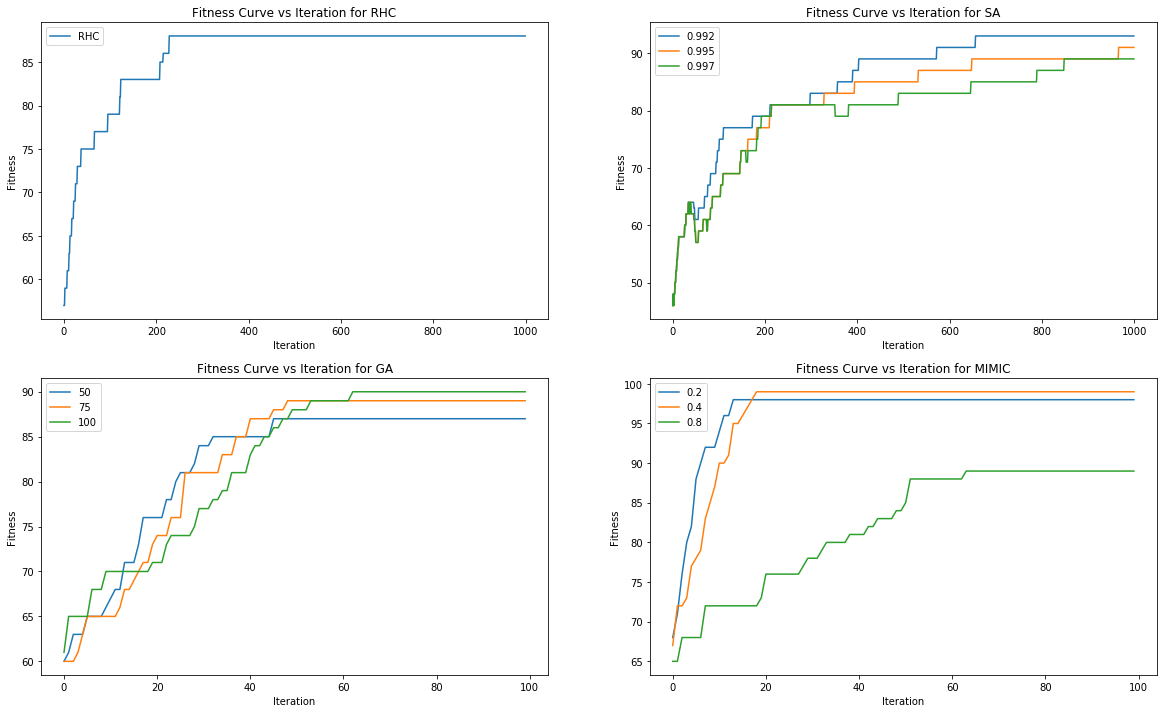

In [40]:
plot_fitness_curve('Flip Flop',ff_rhc,ff_sa,ff_ga,ff_mimic)

In [15]:
df_ff,best_fitness,run_time_ff = randomized_optimization('Flip Flop','all')

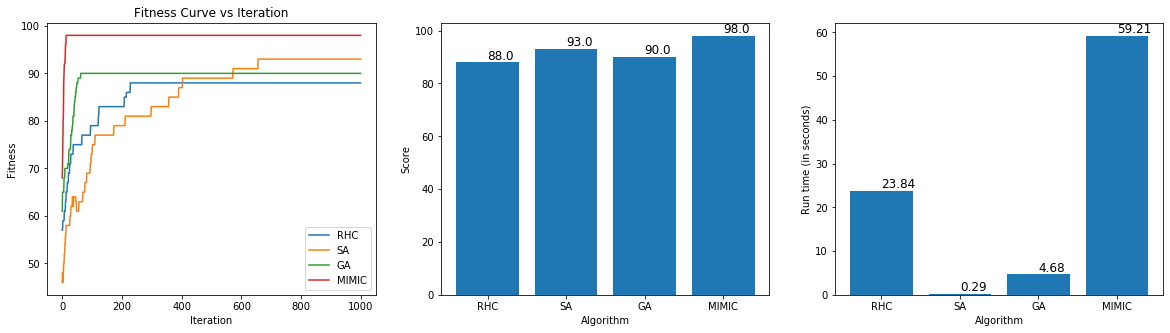

In [39]:
plot_compare_algorithms('Flip Flop',df_ff,best_fitness,run_time_ff)

In [17]:
for item in ('Randomized Hill climb','simulated annealing','genetic algorithm','mimic'):
    df = randomized_optimization('Continous Peak',item)
    if item == 'Randomized Hill climb':
        cp_rhc = df
    elif item == 'simulated annealing':
        cp_sa = df
    elif item == 'genetic algorithm':
        cp_ga = df
    elif item == 'mimic':
        cp_mimic = df

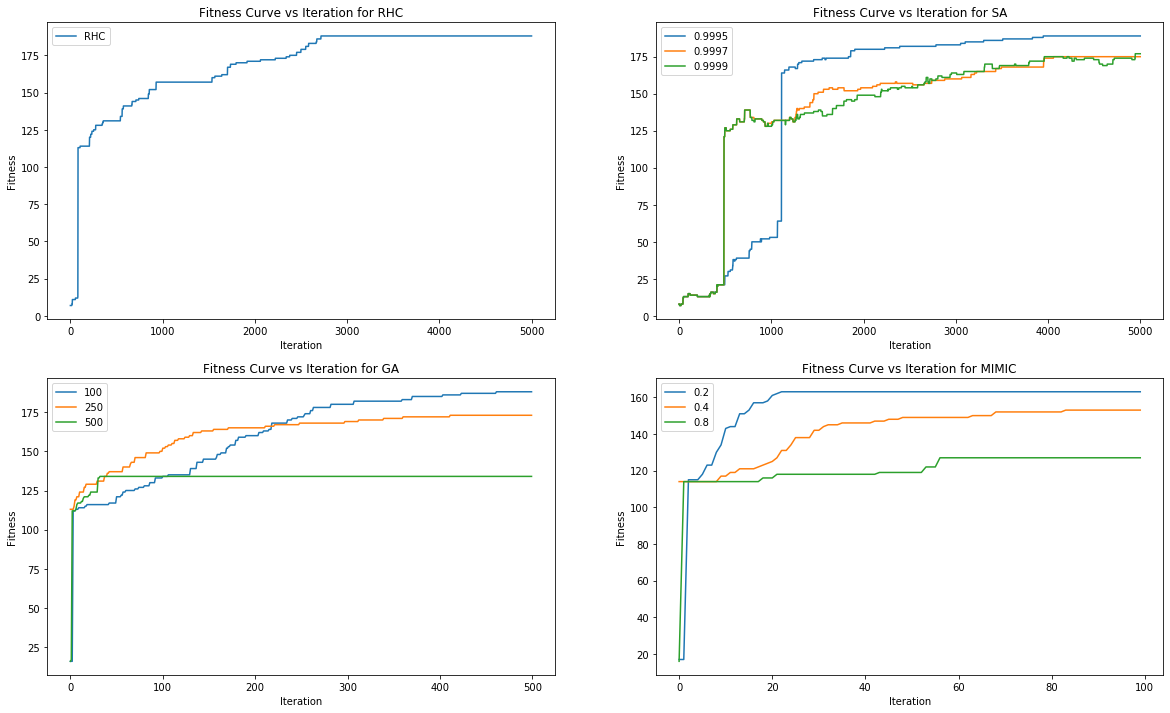

In [18]:
plot_fitness_curve('Continous Peak',cp_rhc,cp_sa,cp_ga,cp_mimic)

In [19]:
df_cp,best_fitness_cp,run_time_cp = randomized_optimization('Continous Peak','all')

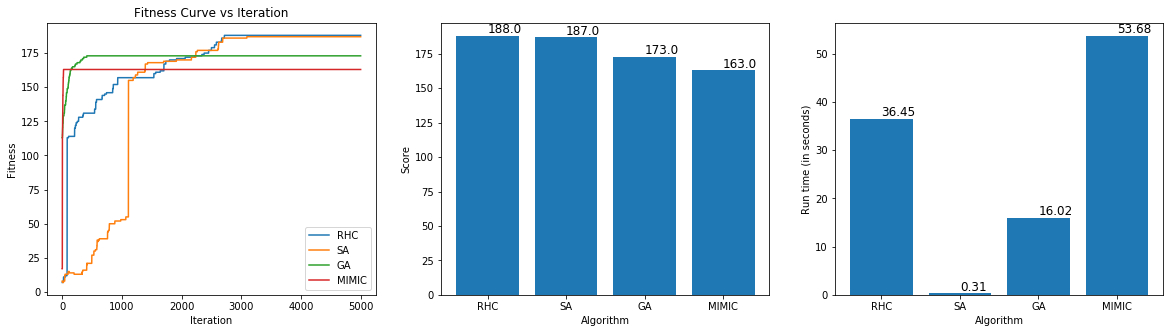

In [20]:
plot_compare_algorithms('Continous Peak',df_cp,best_fitness_cp,run_time_cp)

In [21]:
for item in ('Randomized Hill climb','simulated annealing','genetic algorithm','mimic'):
    df = randomized_optimization('Travelling Salesman',item)
    if item == 'Randomized Hill climb':
        tsp_rhc = df
    elif item == 'simulated annealing':
        tsp_sa = df
    elif item == 'genetic algorithm':
        tsp_ga = df
    elif item == 'mimic':
        tsp_mimic = df

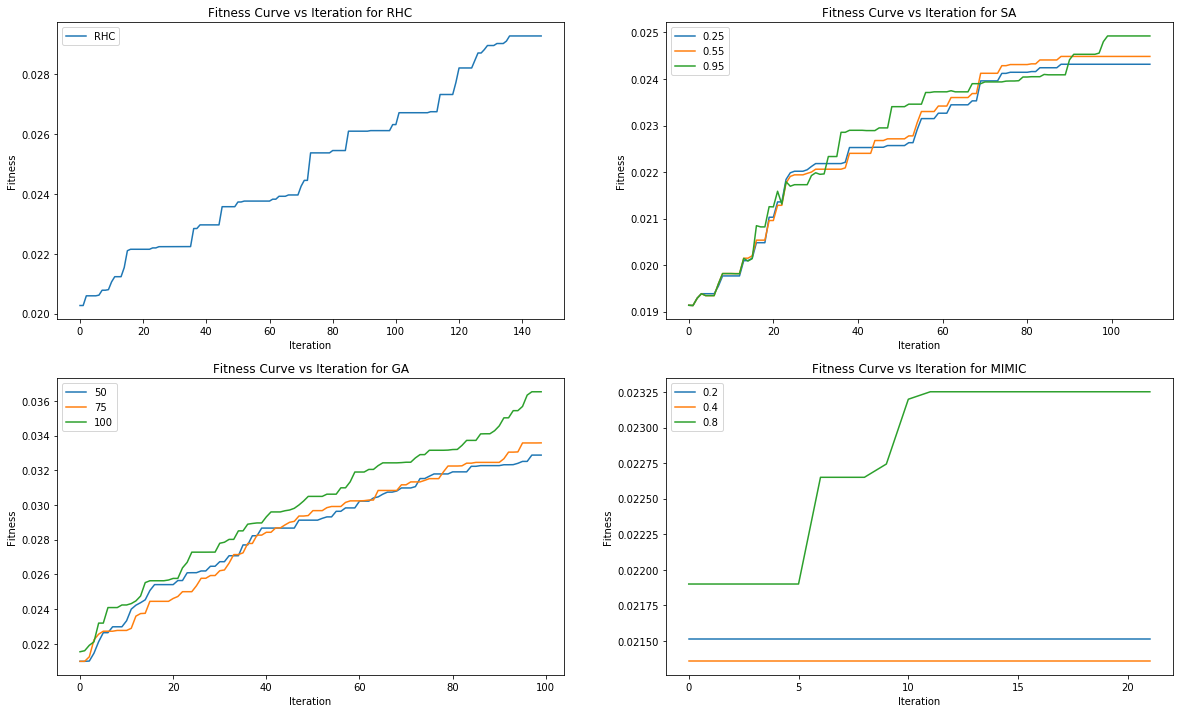

In [22]:
plot_fitness_curve('Travelling Salesman',tsp_rhc,tsp_sa,tsp_ga,tsp_mimic)

In [23]:
df_tsp,best_fitness_tsp,run_time_tsp = randomized_optimization('Travelling Salesman','all')

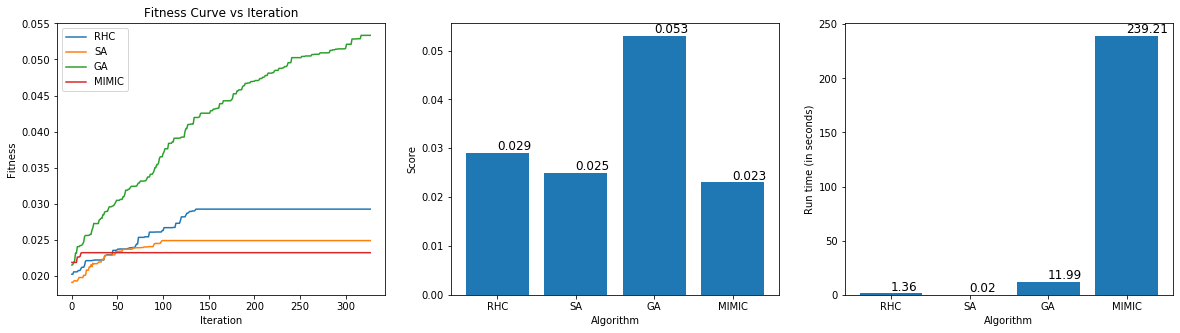

In [24]:
plot_compare_algorithms('Travelling Salesman',df_tsp,best_fitness_tsp,run_time_tsp)

In [25]:
def feature_engineering(file_name):
    if file_name == 'Wine':
        data1 = pd.read_csv('wineQualityWhites.csv')
        data2 = pd.read_csv('wineQualityReds.csv')
        data = data1.append(data2)
        print("Number of rows in wine quality dataset: ", data.shape[0])
        print("Number of attributes in wine quality dataset: ", data.shape[1])
        data.quality = data.quality.apply(lambda x: 1 if x > 5 else 0)
        data.describe(include='all')
    else:
        data = pd.read_csv('dataset.csv').astype('category')
        if data.isnull().values.any():
            print("Warning: Missing Data")
        del data['index']
        print("Number of rows in pishing website dataset: ", data.shape[0])
        print("Number of attributes in pishing website dataset: ", data.shape[1])
        
        cols = ['URLURL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
        data_1hot = data[cols]
        data_1hot = pd.get_dummies(data_1hot)
        df_others = data.drop(cols,axis=1)
        data = pd.concat([data_1hot,df_others],axis=1)
        data = data.replace(-1,0).astype('category')
        column_order = list(data)
        column_order.insert(0, column_order.pop(column_order.index('Result')))
        data = data.loc[:, column_order]
        data.describe(include='all')
    x_data = data.iloc[:,1:-1]
    y_data = data.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, test_size=0.2, random_state=9, shuffle=True, stratify=y_data)
    scaler = StandardScaler()
    x_train = scaler.fit(x_train).transform(x_train)
    x_test = scaler.fit(x_test).transform(x_test)
    return x_train, x_test, y_train, y_test

In [26]:
def NN_weight_optimization(dataset):
    X_train,X_test,y_train,y_test = feature_engineering(dataset)
    curve_lst,accuracy_lst,f1_lst,fit_time_lst = [],[],[],[]
    algorithms =["RHC", "SA", "GA", "Back Propogation"]
    for algorithm in algorithms:
        if algorithm == 'GA':
            learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='genetic_alg', max_iters=1000,max_attempts=100,  learning_rate=1,early_stopping=True, random_state=9, mutation_prob=0.2, pop_size=200,curve=True)
        elif algorithm == 'SA':
            learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='simulated_annealing',max_iters=1000,max_attempts=100,  learning_rate=1,early_stopping=True, schedule=mlrose.GeomDecay(), random_state=9,curve=True)
        elif algorithm == 'RHC' :
            learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='random_hill_climb',max_iters=1000,max_attempts=100, restarts =2,learning_rate=1, early_stopping=True, random_state=9,curve=True)
        else:
            learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='gradient_descent', max_iters=1000,max_attempts=100, learning_rate=1, early_stopping=True, random_state=9,curve=True)      
        time1 = process_time()
        learner.fit(X_train, y_train)
        curve = learner.fitness_curve
        fit_time = ((process_time() - time1) / len(curve))
        if algorithm == "Back Propogation":
            curve *= -1
        y_pred_test = learner.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test)
        curve_lst.append(curve)
        accuracy_lst.append(accuracy)
        f1_lst.append(f1)
        fit_time_lst.append(fit_time) 
    return curve_lst,accuracy_lst,f1_lst,fit_time_lst


In [27]:
wine_curve,wine_accuracy,wine_f1,wine_fit_time = NN_weight_optimization('Wine')

Number of rows in wine quality dataset:  6497
Number of attributes in wine quality dataset:  13


In [28]:
Phishing_curve,Phishing_accuracy,Phishing_f1,Phishing_fit_time = NN_weight_optimization('Phishing')

Number of rows in pishing website dataset:  11055
Number of attributes in pishing website dataset:  31


In [79]:
def plot_alg_comparison(dataset1,dataset2,accuracy1,accuracy2,f1_score1,f1_score2,fit_time1,fit_time2):
    plt.figure()
    _, axes = plt.subplots(1, 2, figsize=(20, 8))
    x = np.arange(4) 
    plt.sca(axes[0])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'Back Propogation'))
    accuracy1 = [ round((elem*100), 2) for elem in accuracy1 ]
    axes[0].bar(x,accuracy1) 
    for i, j in zip(x,accuracy1):
        axes[0].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[0].set_title('Comparison of Accuaracy of algorithms for '+ dataset1)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(0,100)
    
    plt.sca(axes[1])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'Back Propogation'))
    accuracy2 = [ round((elem*100), 2) for elem in accuracy2 ]
    axes[1].bar(x,accuracy2)
    for i, j in zip(x, accuracy2):
        axes[1].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[1].set_title('Comparison of Accuaracy of algorithms for '+ dataset2)
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim(0,100)
    plt.savefig('Accuracy_Comparison.png')
    plt.show()
    
    plt.figure()
    _, axes = plt.subplots(1, 2, figsize=(20, 8))
    x = np.arange(4) 
    plt.sca(axes[0])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'Back Propogation'))
    f1_score1 = [ round((elem*100), 2) for elem in f1_score1 ]
    axes[0].bar(x,f1_score1) 
    for i, j in zip(x,f1_score1):
        axes[0].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[0].set_title('Comparison of F1-score of algorithms for '+ dataset1)
    axes[0].set_ylabel('F1-score')
    axes[0].set_ylim(0,105)
    
    plt.sca(axes[1])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'Back Propogation'))
    f1_score2 = [ round((elem*100), 2) for elem in f1_score2 ]
    axes[1].bar(x,f1_score2)
    for i, j in zip(x, f1_score2):
        axes[1].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[1].set_title('Comparison of F1-score of algorithms for '+ dataset2)
    axes[1].set_ylabel('F1-score')
    axes[1].set_ylim(0,100)
    plt.savefig('F1-score_comparison.png')
    plt.show()
    
    plt.figure()
    _, axes = plt.subplots(1, 2, figsize=(20, 8))
    x = np.arange(4) 
    plt.sca(axes[0])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'Back Propogation'))
    fit_time1 = [ round(elem, 2) for elem in fit_time1 ]
    axes[0].bar(x,fit_time1) 
    for i, j in zip(x,fit_time1):
        axes[0].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[0].set_title('Comparison of Execution time for algorithms for '+ dataset1)
    axes[0].set_ylim(0,100)
    axes[0].set_ylabel('Execution time (seconds)')

    plt.sca(axes[1])
    plt.xticks(x, ('RHC', 'SA', 'GA', 'Back Propogation'))
    fit_time2 = [ round(elem, 2) for elem in fit_time2 ]
    axes[1].bar(x,fit_time2)
    for i, j in zip(x,fit_time2):
        axes[1].text(i, j, str(j), clip_on=True, ha='left',va='bottom', fontsize=12)
    axes[1].set_title('Comparison of Execution time for algorithms for '+ dataset2)
    axes[1].set_ylabel('Execution time (seconds)')
    plt.savefig('Execution_time_Comparison.png')
    plt.show()

<Figure size 432x288 with 0 Axes>

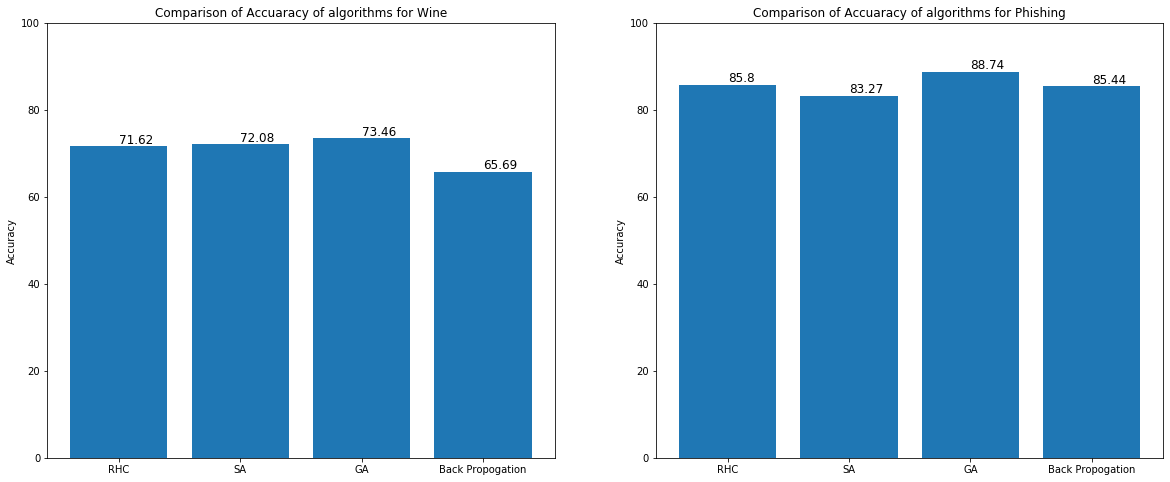

<Figure size 432x288 with 0 Axes>

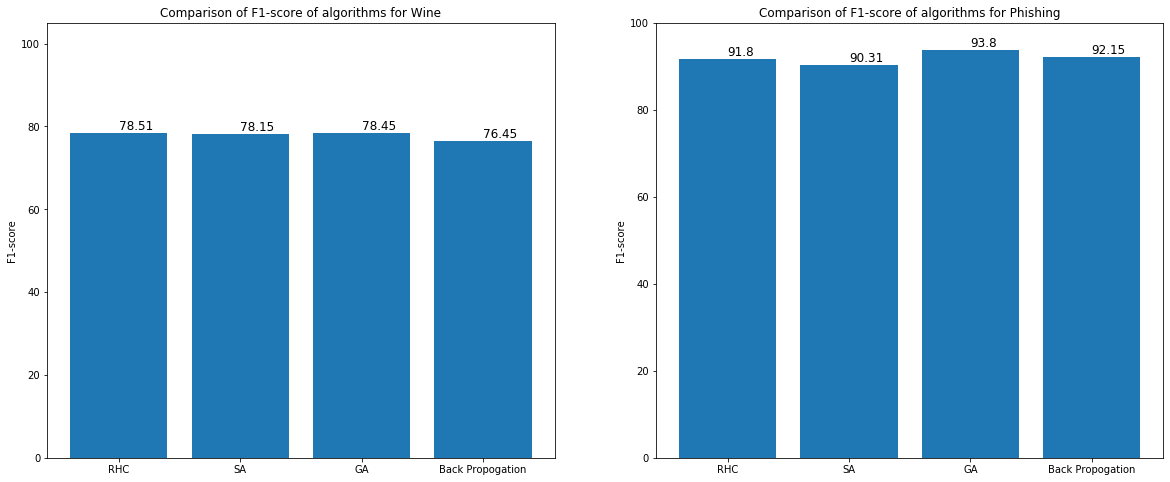

<Figure size 432x288 with 0 Axes>

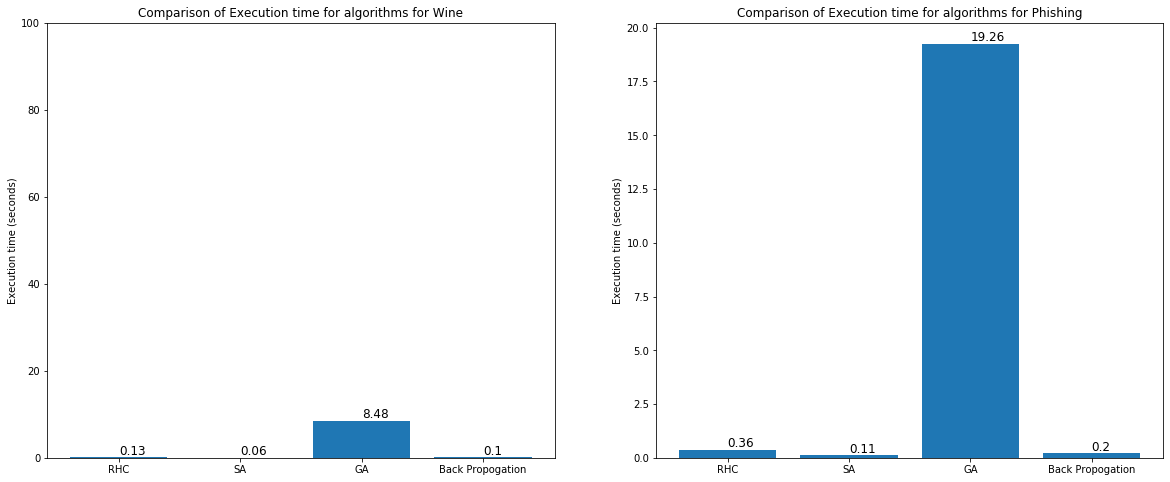

In [80]:
plot_alg_comparison('Wine','Phishing',wine_accuracy,Phishing_accuracy,wine_f1,Phishing_f1,wine_fit_time,Phishing_fit_time)


In [67]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(algo,wine_RHC_estimator,phish_RHC_estimator, X_wine,X_phish, y_wine,y_phish, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(wine_RHC_estimator, X_wine, y_wine,cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True, scoring ='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].set_ylim(0.3,1.01)
    axes[0].set_title("Learning Curve of "+algo+" for wine")
    axes[0].set_xlabel('Training examples')
    axes[0].set_ylabel("Score")
    axes[0].legend(loc="best")

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(phish_RHC_estimator, X_phish, y_phish,cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True, scoring ='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    axes[1].grid()
    axes[1].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[1].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[1].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[1].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[1].set_ylim(0.3,1.01)
    axes[1].set_title("Learning Curve of "+algo+" for Phishing")
    axes[1].set_xlabel('Training examples')
    axes[1].set_ylabel("Score")
    axes[1].legend(loc="best")
    plt.savefig(algo+'learning_curve.png')
    plt.show()
    return plt

In [68]:
X_train,X_test,y_train,y_test = feature_engineering('Wine')
GA_learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='genetic_alg', max_iters=500,max_attempts=50,  learning_rate=1,early_stopping=True, random_state=9, mutation_prob=0.2, pop_size=100,curve=True)
SA_learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='simulated_annealing',max_iters=500,max_attempts=50,  learning_rate=1,early_stopping=True, schedule=mlrose.GeomDecay(), random_state=9,curve=True)
RHC_learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='random_hill_climb',max_iters=500,max_attempts=50, restarts =5,learning_rate=1, early_stopping=True, random_state=9,curve=True)
GD_learner = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='gradient_descent', max_iters=500,max_attempts=50, learning_rate=1, early_stopping=True, random_state=9,curve=True)      
    

Number of rows in wine quality dataset:  6497
Number of attributes in wine quality dataset:  13


In [69]:
X_phish_train,X_phish_test,y_phish_train,y_phish_test = feature_engineering('Phishing')
GA_learner_phish = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='genetic_alg', max_iters=500,max_attempts=50,  learning_rate=1,early_stopping=True, random_state=9, mutation_prob=0.2, pop_size=100,curve=True)
SA_learner_phish = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='simulated_annealing',max_iters=500,max_attempts=50,  learning_rate=1,early_stopping=True, schedule=mlrose.GeomDecay(), random_state=9,curve=True)
RHC_learner_phish = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='random_hill_climb',max_iters=500,max_attempts=50, restarts =5,learning_rate=1, early_stopping=True, random_state=9,curve=True)
GD_learner_phish = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='gradient_descent', max_iters=500,max_attempts=50, learning_rate=1, early_stopping=True, random_state=9,curve=True) 


Number of rows in pishing website dataset:  11055
Number of attributes in pishing website dataset:  31


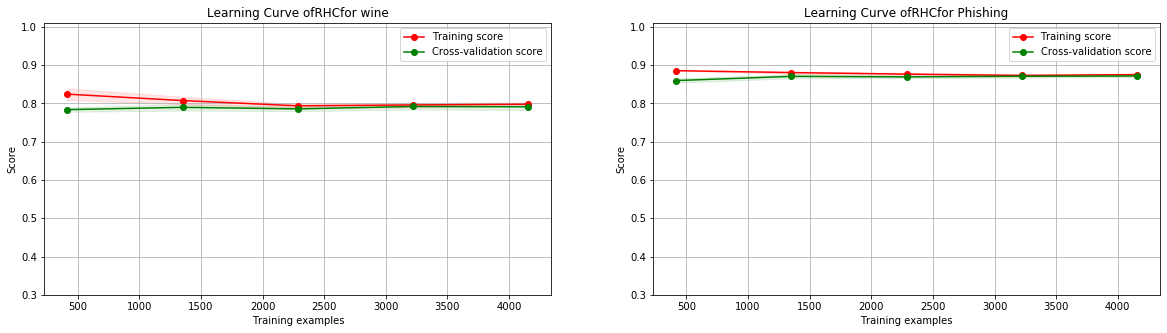

<module 'matplotlib.pyplot' from '/Users/sachin_divz/anaconda3/envs/cs7641hw2/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [70]:
plot_learning_curve("RHC",RHC_learner,RHC_learner_phish,X_train,X_phish_train, y_train,y_phish_train, n_jobs=4)

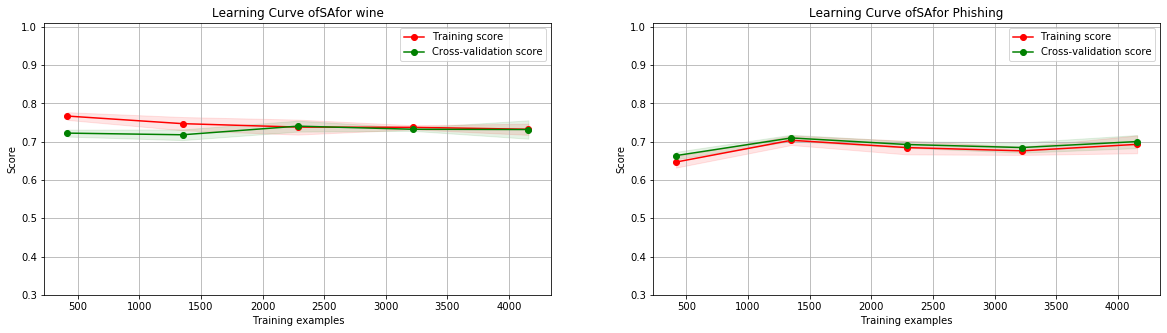

<module 'matplotlib.pyplot' from '/Users/sachin_divz/anaconda3/envs/cs7641hw2/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [71]:
plot_learning_curve("SA",SA_learner,SA_learner_phish ,X_train,X_phish_train, y_train,y_phish_train, n_jobs=4)

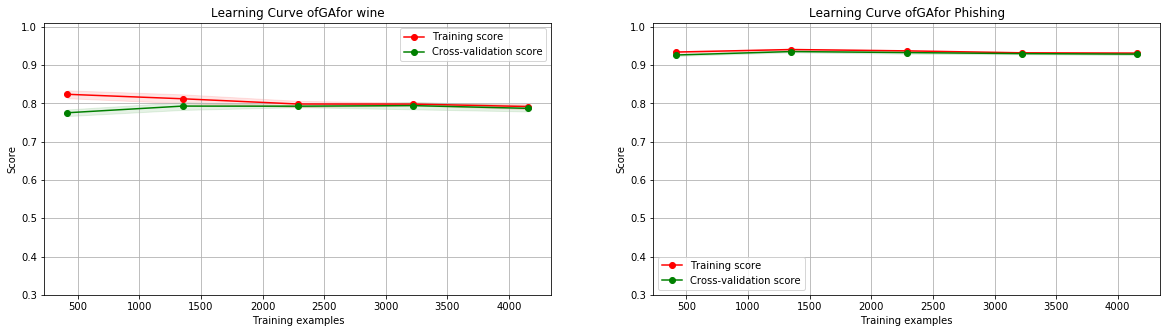

<module 'matplotlib.pyplot' from '/Users/sachin_divz/anaconda3/envs/cs7641hw2/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [72]:
plot_learning_curve("GA",GA_learner,GA_learner_phish ,X_train,X_phish_train, y_train,y_phish_train, n_jobs=4)

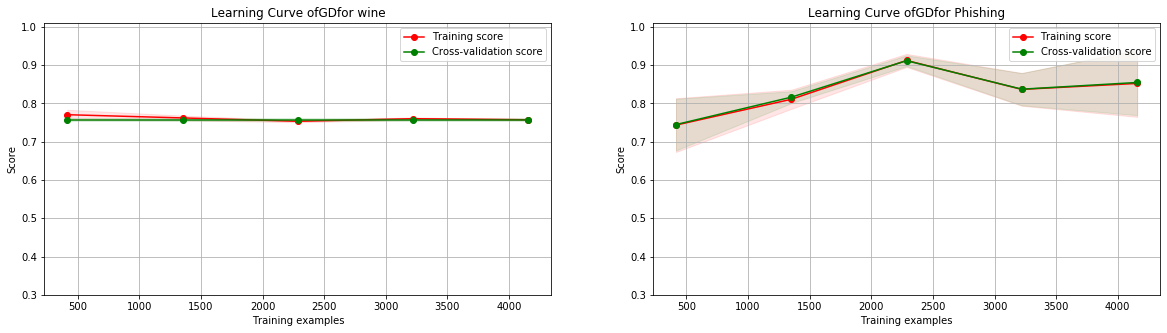

<module 'matplotlib.pyplot' from '/Users/sachin_divz/anaconda3/envs/cs7641hw2/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [73]:
plot_learning_curve("GD",GD_learner,GD_learner_phish,X_train,X_phish_train, y_train,y_phish_train, n_jobs=4)